# RLSS2023 - DQN Tutorial: Deep Q-Network (DQN) - Part I

Website: https://rlsummerschool.com/

Github repository: https://github.com/araffin/rlss23-dqn/

Gymnasium documentation: https://gymnasium.farama.org/

## Introduction

In this notebook, you will implement the main components [Deep Q-Network (DQN)](https://stable-baselines3.readthedocs.io/en/master/modules/dqn.html) algorithm: a replay buffer, epsilon-greedy exploration strategy and a q-network.

In Part II, you will implement the training loop and the DQN gradient update.

In [ ]:
# for autoformatting
%load_ext jupyter_black

## Install Dependencies

In [ ]:
!pip install git+https://github.com/araffin/rlss23-dqn/ --upgrade

### 1. Replay Buffer

The replay buffer is one of the main component of DQN. It contains a collection of transitions, the same way we had a fixed dataset of transitions with FQI. However, compared to FQI, this ring buffer is consistently updated with new experience (and old transitions are dropped when the max capicity is reached).

<div>
    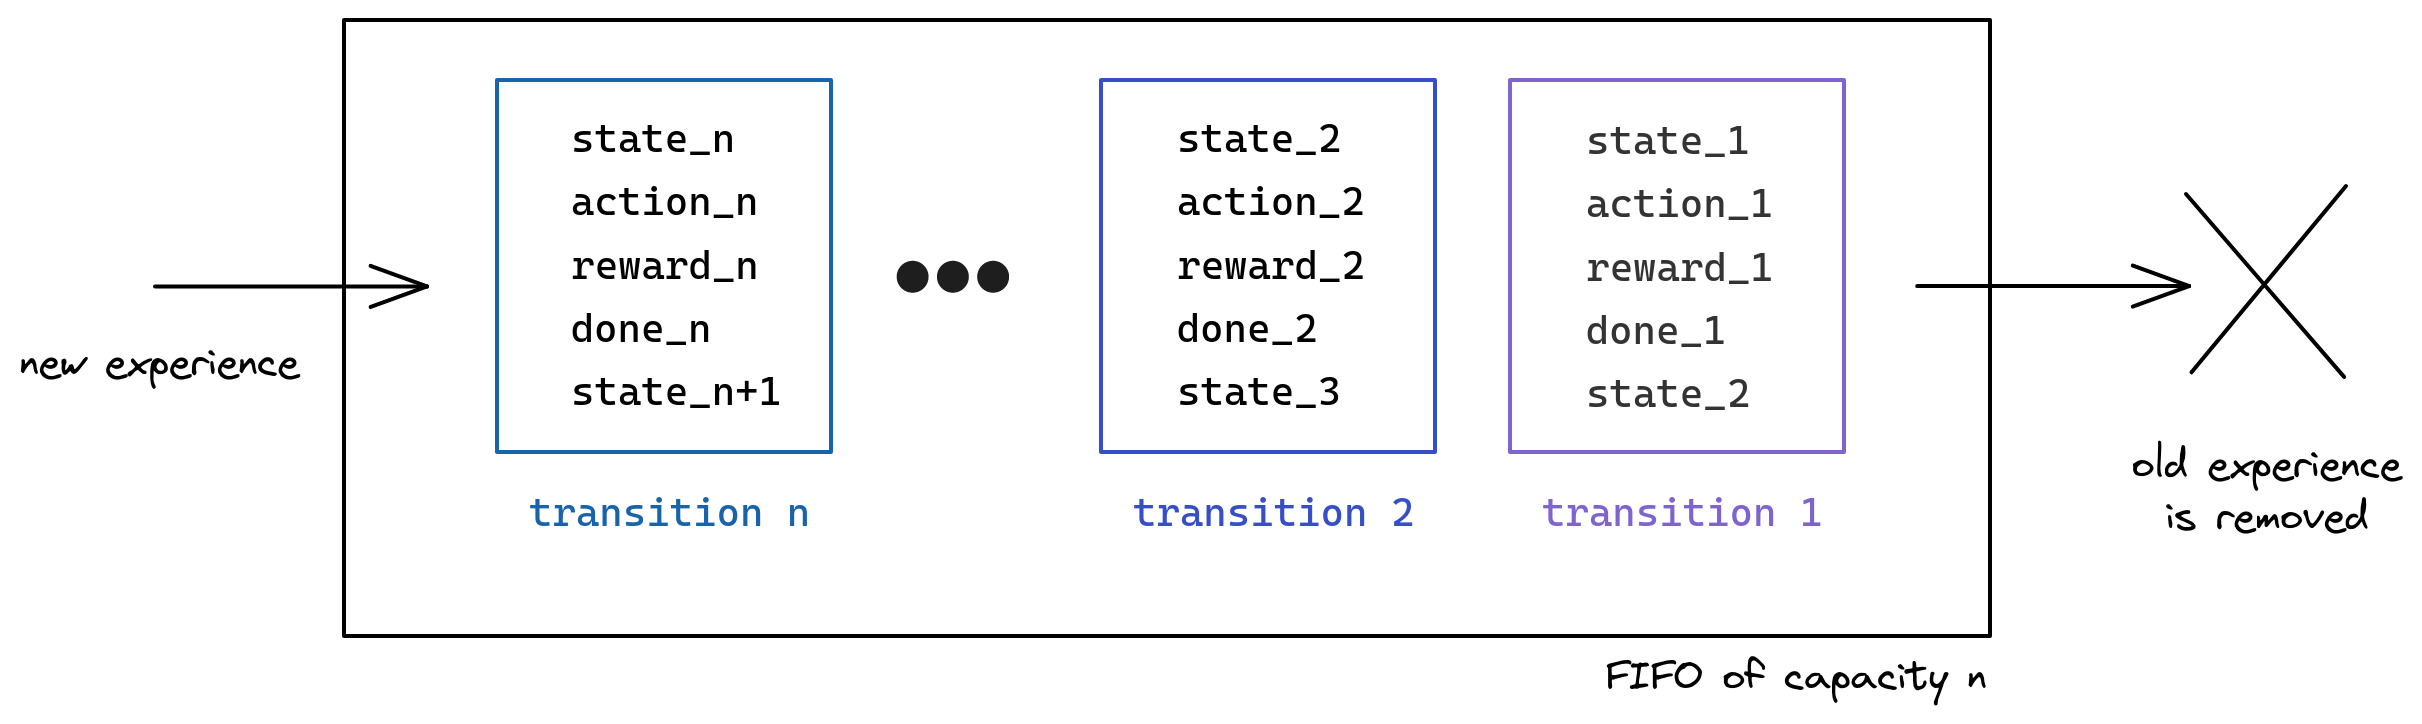
</div>

To update the Q-Network, DQN samples mini-batches from the replay buffer (vs the whole dataset for FQI).

Each mini-batch can be represented using this structure:

```python
@dataclass
class ReplayBufferSamples:
    """
    A dataclass containing transitions from the replay buffer.
    """

    observations: np.ndarray  # same as states in the theory
    next_observations: np.ndarray
    actions: np.ndarray
    rewards: np.ndarray
    terminated: np.ndarray
```

<div>
    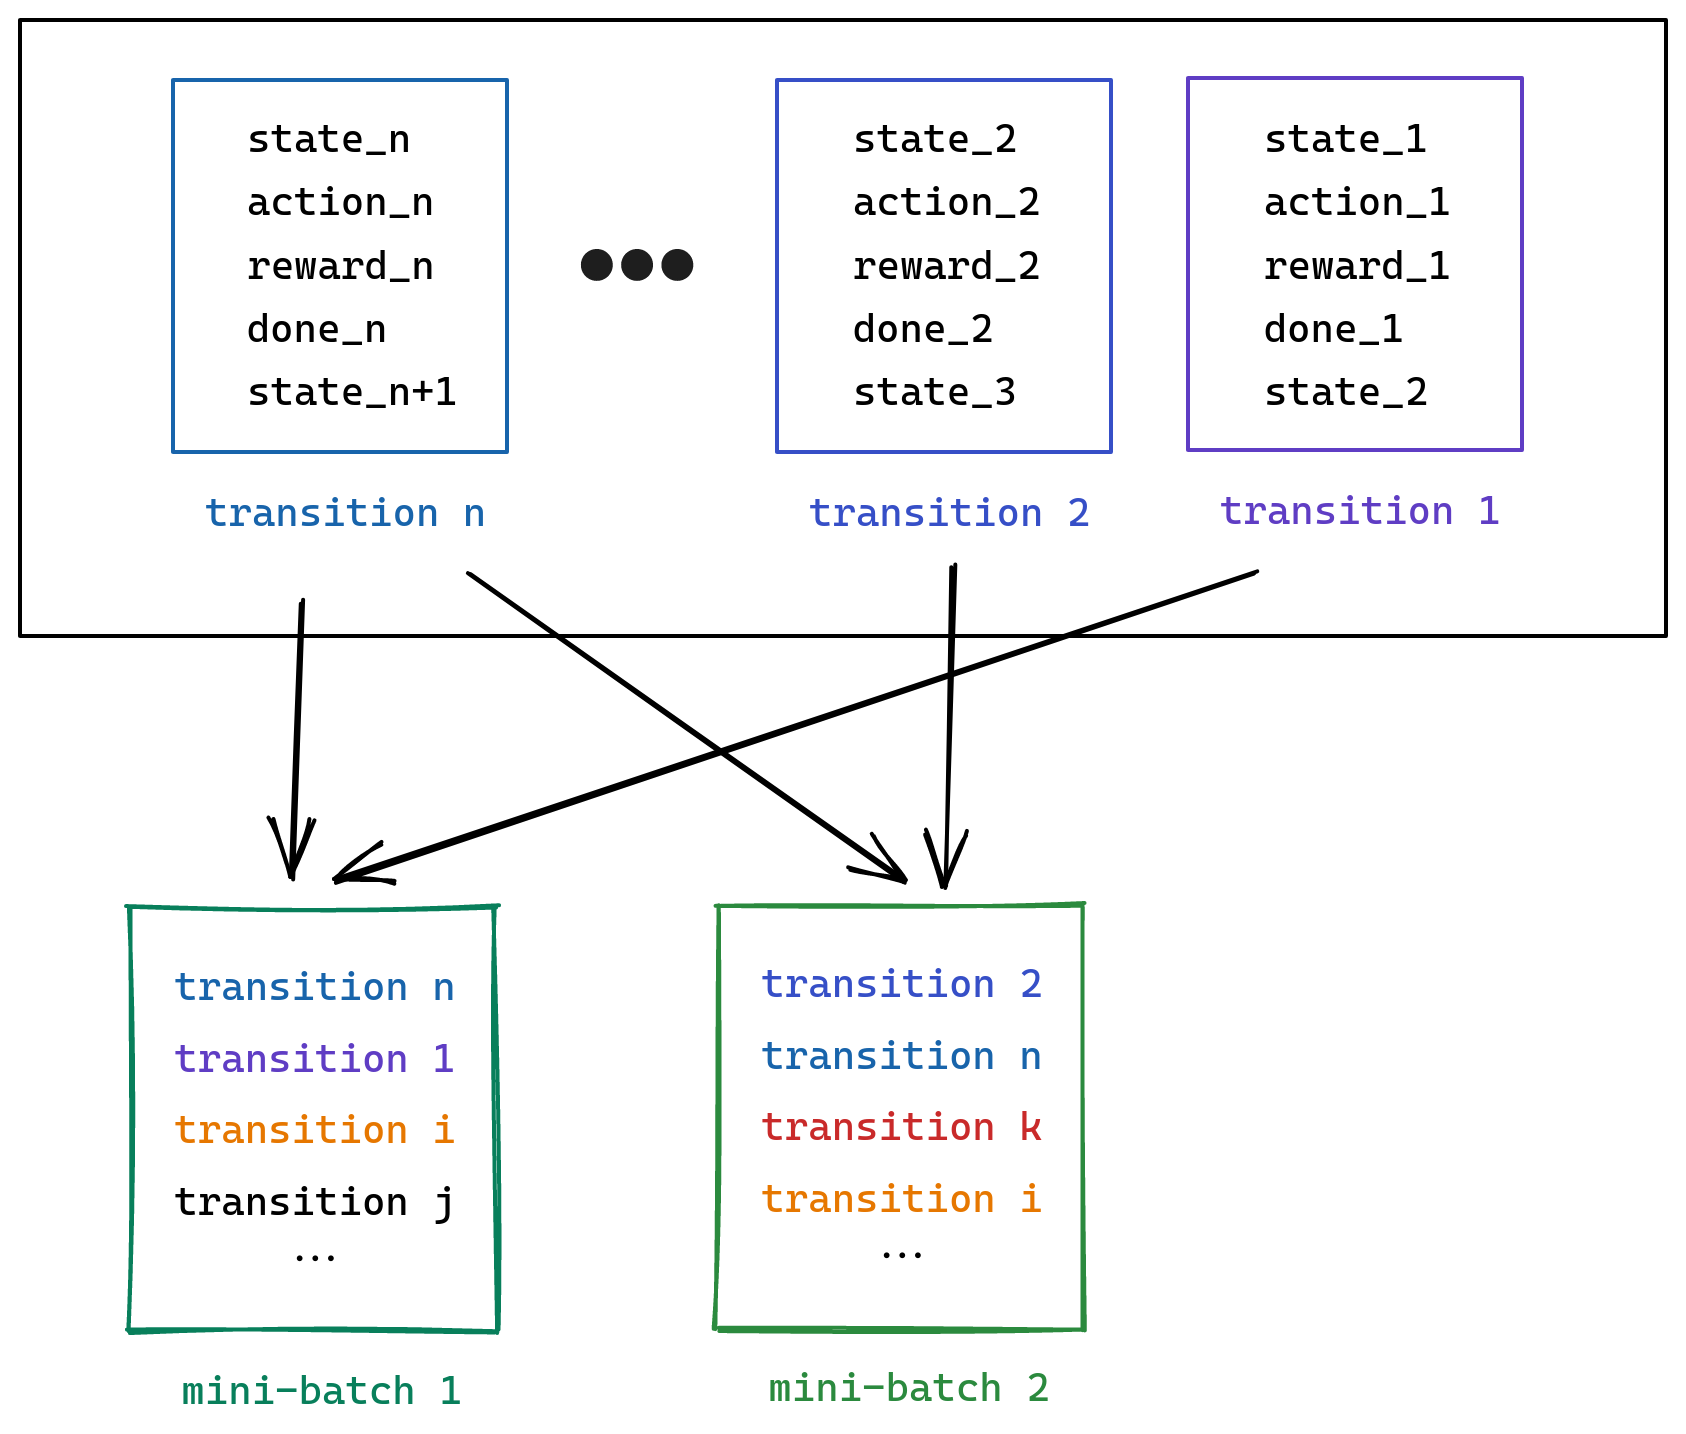
</div>


In [ ]:
from typing import Optional

import numpy as np
import torch as th
from gymnasium import spaces

from dqn_tutorial.dqn.replay_buffer import ReplayBufferSamples

### Exercise (10 minutes): write the replay buffer

In [ ]:
class ReplayBuffer:
    """
    A simple replay buffer class to store and sample transitions.

    :param buffer_size: Max number of transitions to store
    :param observation_space: Observation space of the env,
        contains information about the observation type and shape.
    :param action_space: Action space of the env,
        contains information about the number of actions.
    """

    def __init__(
        self,
        buffer_size: int,
        observation_space: spaces.Box,
        action_space: spaces.Discrete,
    ) -> None:
        # Current position in the ring buffer
        self.current_idx = 0
        self.buffer_size = buffer_size
        # Boolean flag to know when the buffer has reached its maximal capacity
        self.is_full = False

        self.observation_space = observation_space
        self.action_space = action_space
        # Create the different buffers
        self.observations = np.zeros((buffer_size, *observation_space.shape), dtype=observation_space.dtype)
        self.next_observations = np.zeros((buffer_size, *observation_space.shape), dtype=observation_space.dtype)
        # The action is an integer
        action_dim = 1
        self.actions = np.zeros((buffer_size, action_dim), dtype=action_space.dtype)

        ### YOUR CODE HERE
        
        # TODO: create the buffers (numpy arrays) for the rewards (dtype=np.float32)
        # and the terminated signals (dtype=bool)
        self.rewards = np.zeros((buffer_size,), dtype=np.float32)
        self.terminated = np.zeros((buffer_size,), dtype=bool)
        
        ### END OF YOUR CODE

    def store_transition(
        self,
        obs: np.ndarray,
        next_obs: np.ndarray,
        action: int,
        reward: float,
        terminated: bool,
    ) -> None:
        """
        Store one transition in the buffer.

        :param obs: Current observation
        :param next_obs: Next observation
        :param action: Action taken for the current observation
        :param reward: Reward received after taking the action
        :param terminated: Whether it is the end of an episode or not
            (discarding episode truncation like timeout)
        """
        ### YOUR CODE HERE

        # TODO:
        # 1. Update the different buffers defined in the __init__
        # 2. Update the pointer (`self.current_idx`), careful
        # the pointer need to be set to zero when reaching the end of the ring buffer

        # Update the buffers to store the new transition
        self.observations[self.current_idx] = obs
        self.next_observations[self.current_idx] = next_obs
        self.actions[self.current_idx] = action
        self.rewards[self.current_idx] = reward
        self.terminated[self.current_idx] = terminated

        # Update the pointer
        self.current_idx += 1
        # If the buffer is full, we start from zero again, this is a ring buffer
        # you also need to set the flag `is_full` to True (so we know the buffer has reached its max capacity)
        if self.current_idx == self.buffer_size:
            self.is_full = True
            self.current_idx = 0

        ### END OF YOUR CODE

    def sample(self, batch_size: int) -> ReplayBufferSamples:
        """
        Sample with replacement `batch_size` transitions from the buffer.

        :param batch_size: How many transitions to sample.
        :return: Samples from the replay buffer
        """
        ### YOUR CODE HERE

        # TODO:
        # 1. Retrieve the upper bound (max index that can be sampled)
        #  it corresponds to `self.buffer_size` when the ring buffer is full (we can samples all indices)
        # 2. Sample `batch_size` indices with replacement from the buffer
        # (in the range [0, upper_bound[ ), numpy has a method `np.random.randint` for that ;)
        upper_bound = self.buffer_size if self.is_full else self.current_idx
        batch_indices = np.random.randint(0, upper_bound, size=batch_size)

        ### END OF YOUR CODE

        return ReplayBufferSamples(
            self.observations[batch_indices],
            self.next_observations[batch_indices],
            self.actions[batch_indices],
            self.rewards[batch_indices],
            self.terminated[batch_indices],
        )

testing the replay buffer, without reaching max capacity:

In [ ]:
import gymnasium as gym

env = gym.make("CartPole-v1")

buffer_size = 1000
buffer = ReplayBuffer(buffer_size, env.observation_space, env.action_space)
obs, _ = env.reset()
# Fill the buffer
for _ in range(500):
    action = int(env.action_space.sample())
    next_obs, reward, terminated, truncated, _ = env.step(action)
    # Store new transition in the replay buffer
    buffer.store_transition(obs, next_obs, action, float(reward), terminated)
    # Update current observation
    obs = next_obs

    done = terminated or truncated
    if done:
        obs, _ = env.reset()

assert not buffer.is_full
assert buffer.current_idx == 500
samples = buffer.sample(batch_size=10)
assert len(samples.observations) == 10
assert samples.actions.shape == (10, 1)

Testing the replay buffer when reaching max capacity:

In [ ]:
# Fill the buffer completely
for _ in range(1000):
    action = int(env.action_space.sample())
    next_obs, reward, terminated, truncated, _ = env.step(action)
    buffer.store_transition(obs, next_obs, action, float(reward), terminated)
    # Update current observation
    obs = next_obs

    done = terminated or truncated
    if done:
        obs, _ = env.reset()

assert buffer.is_full
# We did a full loop
assert buffer.current_idx == 500
# Check sampling with replacement
# we should be able to sample more transitions
# than the capacity of the ring buffer
samples = buffer.sample(batch_size=1001)
assert len(samples.observations) == 1001
assert samples.actions.shape == (1001, 1)

### 2. Q-Network

<div>
    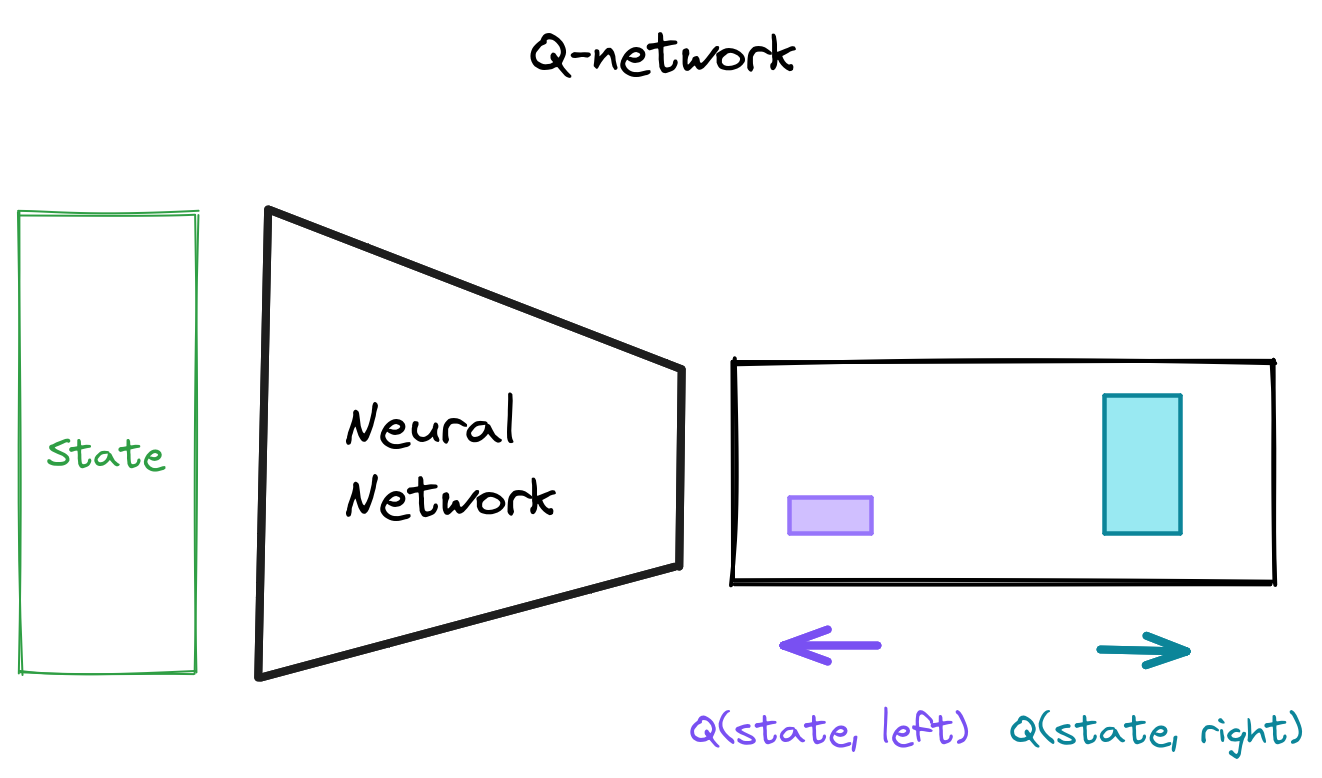
</div>

Similiar to FQI, the Q-Network estimates $Q_\pi(s_t, a_t)$, however, instead of taking the action as input, it outputs q-values for all possible actions as output.

### Exercise (7 minutes): write the Q-Network using PyTorch

In [ ]:
from typing import Type

import torch as th
import torch.nn as nn
from gymnasium import spaces


class QNetwork(nn.Module):
    """
    A Q-Network for the DQN algorithm
    to estimate the q-value for a given observation.

    :param observation_space: Observation space of the env,
        contains information about the observation type and shape.
    :param action_space: Action space of the env,
        contains information about the number of actions.
    :param n_hidden_units: Number of units for each hidden layer.
    :param activation_fn: Activation function (ReLU by default)
    """

    def __init__(
        self,
        observation_space: spaces.Box,
        action_space: spaces.Discrete,
        n_hidden_units: int = 64,
        activation_fn: Type[nn.Module] = nn.ReLU,
    ) -> None:
        super().__init__()
        # Assume 1d space
        obs_dim = observation_space.shape[0]

        ### YOUR CODE HERE
        # TODO:
        # 1. Retrieve the number of discrete actions,
        # that will be the number of ouputs of the q-network
        # 2. Create the q-network, it will be a two layers fully-connected
        # neural network which take the state (observation) as input
        # and outputs the q-values for all possible actions

        # Retrieve the number of discrete actions (using attribute `n` from `action_space`)
        n_actions = int(action_space.n)

        # Create the q network: a 2 fully connected hidden layers with `n_hidden_units` each
        # with `activation_fn` for the activation function after each hidden layer.
        # You should use `nn.Sequential` (combine several layers to create a network)
        # `nn.Linear` (fully connected layer) from PyTorch.
        self.q_net = nn.Sequential(
            nn.Linear(obs_dim, n_hidden_units),
            activation_fn(),
            nn.Linear(n_hidden_units, n_hidden_units),
            activation_fn(),
            nn.Linear(n_hidden_units, n_actions),
        )

        ### END OF YOUR CODE

    def forward(self, observations: th.Tensor) -> th.Tensor:
        """
        :param observations: A batch of observation (batch_size, obs_dim)
        :return: The Q-values for the given observations
            for all the action (batch_size, n_actions)
        """
        return self.q_net(observations)

To test your Q-Network:

In [ ]:
env = gym.make("CartPole-v1")
q_net = QNetwork(env.observation_space, env.action_space)

print(q_net)

obs, _ = env.reset()

with th.no_grad():
    # Create the input to the Q-Network
    obs_tensor = th.as_tensor(obs[np.newaxis, ...])
    q_values = q_net(obs_tensor)

    assert q_values.shape == (1, 2)

    best_action = q_values.argmax().item()

    assert isinstance(best_action, int)

### 3. Epsilon-greedy data collection

### Exercise (10 minutes): write the epsilon-greedy action selection strategy

<div>
    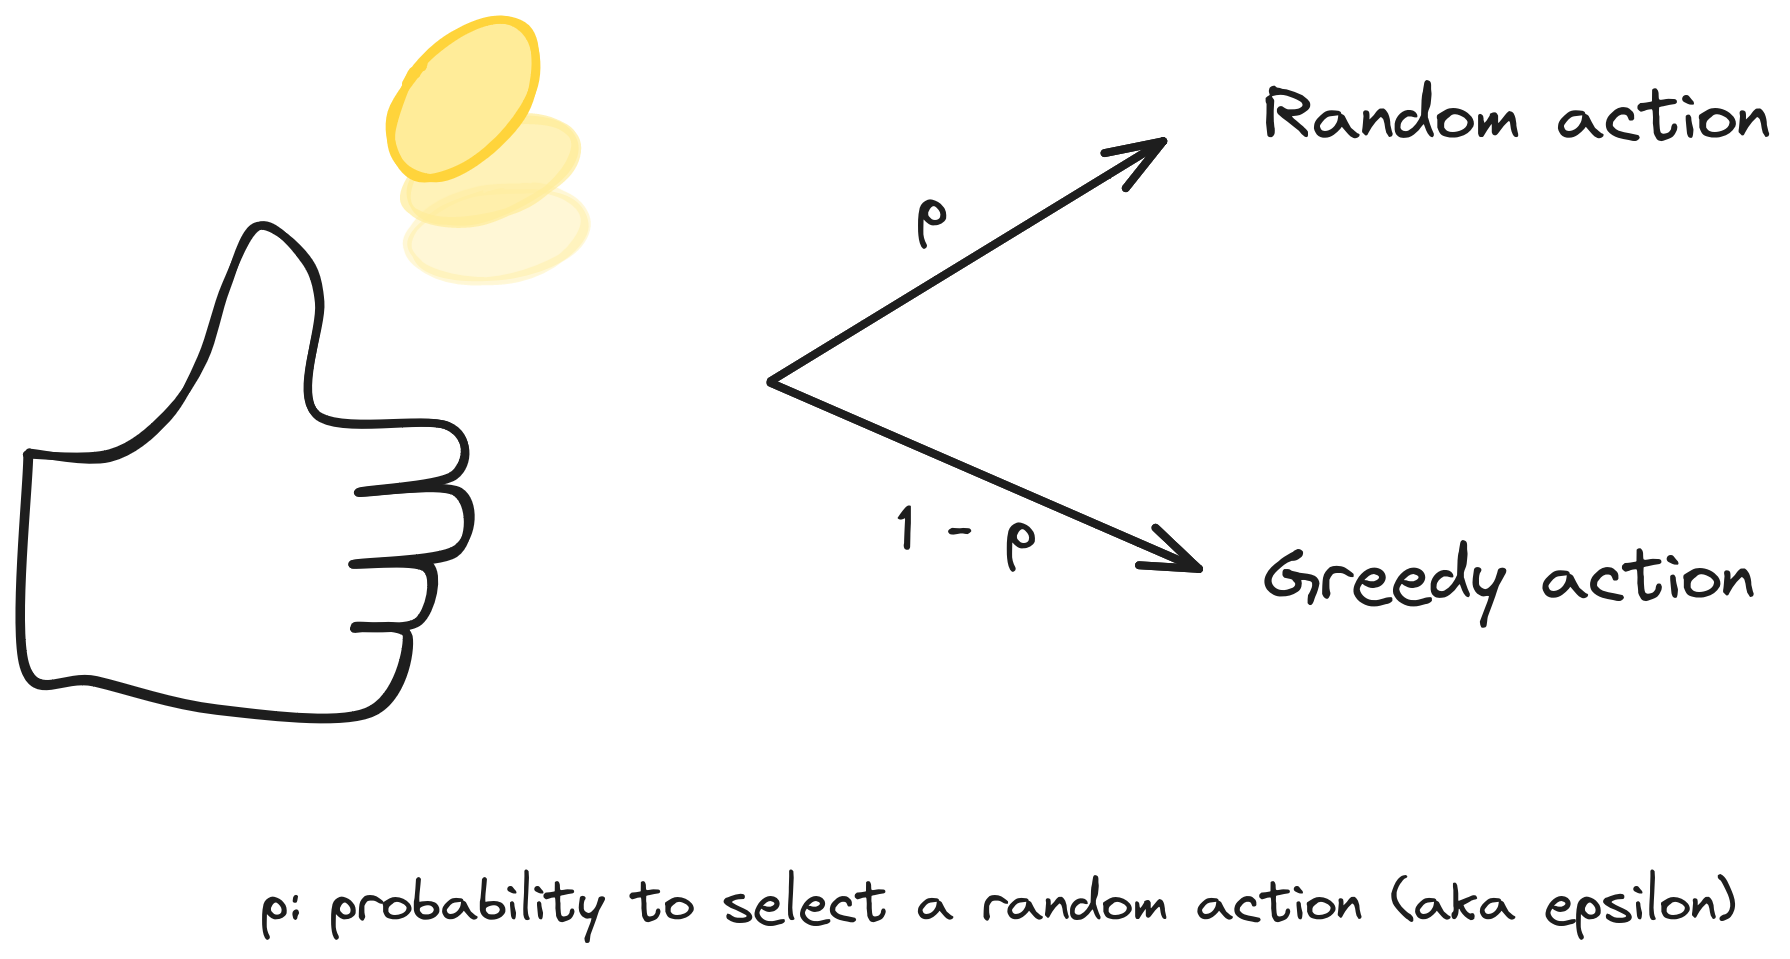
</div>

In [ ]:
def epsilon_greedy_action_selection(
    q_net: QNetwork,
    observation: np.ndarray,
    exploration_rate: float,
    action_space: spaces.Discrete,
    device: str = "cpu",
) -> int:
    """
    Select an action according to an espilon-greedy policy:
    with a probability of epsilon (`exploration_rate`),
    sample a random action, otherwise follow the best known action
    according to the q-value.

    :param observation: A single observation.
    :param q_net: Q-network for estimating the q value
    :param exploration_rate: Current rate of exploration (in [0, 1], 0 means no exploration),
        probability to select a random action,
        this is "epsilon".
    :param action_space: Action space of the env,
        contains information about the number of actions.
    :param device: PyTorch device
    :return: An action selected according to the epsilon-greedy policy.
    """
    ### YOUR CODE HERE
    # TODO:
    # 1. Toss a biased coin (you can use `np.random.rand()`)
    # to decide if the agent should take a random action or not
    # (with probability p=`exploration_rate`)
    # 2. Either take a random action (sample the action space)
    # or follow the greedy policy (take the action with the highest q-value)

    if np.random.rand() < exploration_rate:
        # Random action
        action = int(action_space.sample())
    else:
        # Greedy action
        # We do not need to compute the gradient, so we use `with th.no_grad():`
        with th.no_grad():
            # Convert the input to PyTorch tensor and add a batch dimension (obs_dim,) -> (1, obs_dim)
            # you can use `th.as_tensor` and numpy `[np.newaxis, ...]`
            obs_tensor = th.as_tensor(observation[np.newaxis, ...], device=device)
            # Compute q values for all actions
            q_values = q_net(obs_tensor)
            # Greedy policy: select action with the highest q value
            # you can use PyTorch `.argmax()` for that
            action = q_values.argmax().item()

    ### END OF YOUR CODE

    return action

### Exercise (7 minutes): Collect one transition and store it in the replay buffer

In [ ]:
def collect_one_step(
    env: gym.Env,
    q_net: QNetwork,
    replay_buffer: ReplayBuffer,
    obs: np.ndarray,
    exploration_rate: float = 0.1,
    verbose: int = 0,
) -> np.ndarray:
    """
    Collect one transition and fill the replay buffer following an epsilon greedy policy.

    :param env: The environment object.
    :param q_net: Q-network for estimating the q value
    :param replay_buffer: Replay buffer to store the new transitions.
    :param obs: The current observation.
    :param exploration_rate: Current rate of exploration (in [0, 1], 0 means no exploration),
        probability to select a random action,
        this is "epsilon".
    :param verbose: The verbosity level (1 to print some info).
    :return: The last observation (important when collecting data multiple times).
    """
    ### YOUR CODE HERE

    # Select an action following an epsilon-greedy policy
    # you should use `epsilon_greedy_action_selection()`
    action = epsilon_greedy_action_selection(q_net, obs, exploration_rate, env.action_space)
    # Step in the env
    next_obs, reward, terminated, truncated, info = env.step(action)
    # Store the transition in the replay buffer
    replay_buffer.store_transition(obs, next_obs, action, float(reward), terminated)
    # Update current observation
    obs = next_obs

    ### END OF YOUR CODE

    if "episode" in info and verbose >= 1:
        print(f"Episode return={float(info['episode']['r']):.2f} length={int(info['episode']['l'])}")

    done = terminated or truncated
    if done:
        # Don't forget to reset the env at the end of an episode
        obs, _ = env.reset()
    return obs

Let's test the data collection:

In [ ]:
env = gym.make("CartPole-v1")
q_net = QNetwork(env.observation_space, env.action_space)
buffer = ReplayBuffer(2000, env.observation_space, env.action_space)

obs, _ = env.reset()
for _ in range(1000):
    obs = collect_one_step(env, q_net, buffer, obs, exploration_rate=0.1)
    
# Check current buffer position
assert buffer.current_idx == 1000

# Collect more data
for _ in range(1000):
    obs = collect_one_step(env, q_net, buffer, obs, exploration_rate=0.1)
    
# Buffer is full
assert buffer.current_idx == 0
assert buffer.is_full

### Bonus: Exploration Schedule

<div>
    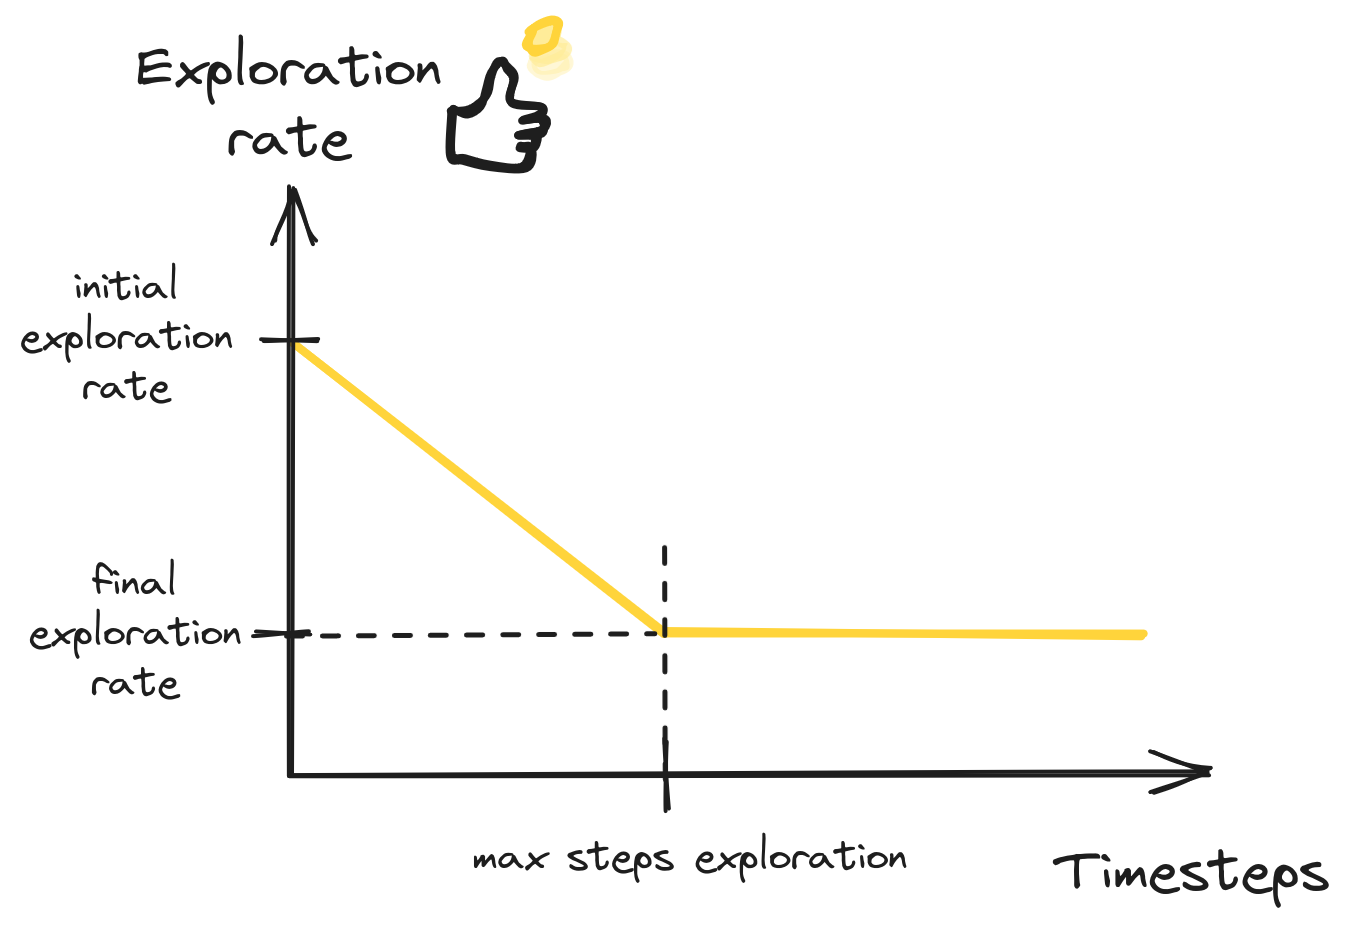
</div>


In [ ]:
def linear_schedule(initial_value: float, final_value: float, current_step: int, max_steps: int) -> float:
    """
    Linear schedule for the exploration rate (epsilon).
    Note: we clip the value so the schedule is constant after reaching the final value
    at `max_steps`.

    :param initial_value: Initial value of the schedule.
    :param final_value: Final value of the schedule.
    :param current_step: Current step of the schedule.
    :param max_steps: Maximum number of steps of the schedule.
    :return: The current value of the schedule.
    """
    ### YOUR CODE HERE
    
    # Compute current progress (in [0, 1], 0 being the start)
    progress = current_step / max_steps
    # Clip the progress so the schedule is constant after reaching the final value
    progress = min(progress, 1.0)
    current_value = initial_value + progress * (final_value - initial_value)

    ### END OF YOUR CODE
    
    return current_value

To test the linear schedule:

In [ ]:
# Linear schedule
exploration_initial_eps = 1.0
exploration_final_eps = 0.01
exploration_rate = exploration_initial_eps
n_steps = 100
for step in range(n_steps + 1):
    exploration_rate = linear_schedule(exploration_initial_eps, exploration_final_eps, step, n_steps)
    if step == 0:
        assert exploration_rate == exploration_initial_eps

    obs = collect_one_step(env, q_net, buffer, obs, exploration_rate=exploration_rate)

assert np.allclose(exploration_rate, exploration_final_eps)

### Conclusion

In this notebook, you have seen how to implement the main components of DQN:
- how to create a replay buffer
- how to sample actions according to an espilon-greedy exploration strategy
- how to create a Q-Network


In part II, we will put everything together to finalize DQN implementation.
We will see how to implement the DQN update using gradient descent and how to implement the training loop that alternates between data collection and updating the Q-Network. 